In [1]:
from omegaconf import OmegaConf
import os, sys
import torch
import glob
import pickle
import pandas as pd
import numpy as np
from scipy.stats import norm as scipy_norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_lightning import Trainer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models import UNet, CuboidTransformerModel
from utils.visualization import report_SEVIR_statistics
from models.lightning import SEVIRPLModule

In [2]:
model_name="earthformer"
save_dir = "../models/experiments/{}/".format(model_name)
oc_file = os.path.join(save_dir, "cfg.yaml")
checkpoints = os.path.join(save_dir, "checkpoints/")
logs = os.path.join(save_dir, "lightning_logs/")
examples = os.path.join(save_dir, "examples/")
scores = os.path.join(save_dir, "scores/")

In [3]:
oc_from_file = OmegaConf.load(open(oc_file, "r"))
model_cfg = oc_from_file["model"]
loss_cfg = oc_from_file["loss"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
micro_batch_size=1
dm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm.prepare_data()
dm.setup()

dataset_oc["dataset_name"] = "storm"
dm_storm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm_storm.prepare_data()
dm_storm.setup()

dataset_oc["dataset_name"] = "random"
dm_random = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm_random.prepare_data()
dm_random.setup()

In [5]:
# if model_cfg["name"] == "earthformer":
#     model = CuboidTransformerModel(
#         input_shape=model_cfg["input_shape"],
#         target_shape=model_cfg["target_shape"],
#         base_units=model_cfg["base_units"],
#         block_units=model_cfg["block_units"],
#         scale_alpha=model_cfg["scale_alpha"],
#         enc_depth=model_cfg["enc_depth"],
#         dec_depth=model_cfg["dec_depth"],
#         enc_use_inter_ffn=model_cfg["enc_use_inter_ffn"],
#         dec_use_inter_ffn=model_cfg["dec_use_inter_ffn"],
#         dec_hierarchical_pos_embed=model_cfg["dec_hierarchical_pos_embed"],
#         downsample=model_cfg["downsample"],
#         downsample_type=model_cfg["downsample_type"],
#         enc_attn_patterns=enc_attn_patterns,
#         dec_self_attn_patterns=dec_self_attn_patterns,
#         dec_cross_attn_patterns=dec_cross_attn_patterns,
#         dec_cross_last_n_frames=model_cfg["dec_cross_last_n_frames"],
#         dec_use_first_self_attn=model_cfg["dec_use_first_self_attn"],
#         num_heads=model_cfg["num_heads"],
#         attn_drop=model_cfg["attn_drop"],
#         proj_drop=model_cfg["proj_drop"],
#         ffn_drop=model_cfg["ffn_drop"],
#         upsample_type=model_cfg["upsample_type"],
#         ffn_activation=model_cfg["ffn_activation"],
#         gated_ffn=model_cfg["gated_ffn"],
#         norm_layer=model_cfg["norm_layer"],
#         # global vectors
#         num_global_vectors=model_cfg["num_global_vectors"],
#         use_dec_self_global=model_cfg["use_dec_self_global"],
#         dec_self_update_global=model_cfg["dec_self_update_global"],
#         use_dec_cross_global=model_cfg["use_dec_cross_global"],
#         use_global_vector_ffn=model_cfg["use_global_vector_ffn"],
#         use_global_self_attn=model_cfg["use_global_self_attn"],
#         separate_global_qkv=model_cfg["separate_global_qkv"],
#         global_dim_ratio=model_cfg["global_dim_ratio"],
#         # initial_downsample
#         initial_downsample_type=model_cfg["initial_downsample_type"],
#         initial_downsample_activation=model_cfg["initial_downsample_activation"],
#         # initial_downsample_type=="stack_conv"
#         initial_downsample_stack_conv_num_layers=model_cfg["initial_downsample_stack_conv_num_layers"],
#         initial_downsample_stack_conv_dim_list=model_cfg["initial_downsample_stack_conv_dim_list"],
#         initial_downsample_stack_conv_downscale_list=model_cfg["initial_downsample_stack_conv_downscale_list"],
#         initial_downsample_stack_conv_num_conv_list=model_cfg["initial_downsample_stack_conv_num_conv_list"],
#         # misc
#         padding_type=model_cfg["padding_type"],
#         z_init_method=model_cfg["z_init_method"],
#         checkpoint_level=model_cfg["checkpoint_level"],
#         pos_embed_type=model_cfg["pos_embed_type"],
#         use_relative_pos=model_cfg["use_relative_pos"],
#         self_attn_use_final_proj=model_cfg["self_attn_use_final_proj"],
#         # initialization
#         attn_linear_init_mode=model_cfg["attn_linear_init_mode"],
#         ffn_linear_init_mode=model_cfg["ffn_linear_init_mode"],
#         conv_init_mode=model_cfg["conv_init_mode"],
#         down_up_linear_init_mode=model_cfg["down_up_linear_init_mode"],
#         norm_init_mode=model_cfg["norm_init_mode"],
#         edl = loss_cfg["edl"],
#         edl_act = loss_cfg["edl_act"],
#     ).to(device)
# elif model_cfg["name"] == "unet":
#     model = UNet(
#         input_shape=model_cfg["input_shape"],
#         target_shape=model_cfg["target_shape"],
#         enc_nodes=model_cfg["enc_nodes"],
#         center=model_cfg["center"],
#         dec_nodes=model_cfg["dec_nodes"],
#         activation=model_cfg["activation"],
#         edl = loss_cfg["edl"],
#         edl_act = loss_cfg["edl_act"],
#     ).to(device)
    
# model.load_state_dict(torch.load(os.path.join(checkpoints, "_sevir.pt")))

In [6]:
ckpts = glob.glob(checkpoints + '*.ckpt')
print(ckpts)
curr_ckpt = ckpts[1]
print(curr_ckpt)

['../models/experiments/earthformer/checkpoints/model-epoch=039.ckpt', '../models/experiments/earthformer/checkpoints/last.ckpt', '../models/experiments/earthformer/checkpoints/model-epoch=003.ckpt', '../models/experiments/earthformer/checkpoints/last-v1.ckpt']
../models/experiments/earthformer/checkpoints/last.ckpt


In [7]:
total_num_steps = SEVIRPLModule.get_total_num_steps(
    epoch=oc_from_file.optim.max_epochs,
    num_samples=dm.num_train_samples,
    total_batch_size=oc_from_file.optim.total_batch_size,
)
pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt, total_num_steps=total_num_steps, save_dir=model_name, oc_file=oc_file)
accumulate_grad_batches = oc_from_file.optim.total_batch_size // (oc_from_file.optim.micro_batch_size * 1)
trainer_kwargs = pl_module.set_trainer_kwargs(
    devices= 1,
    accumulate_grad_batches=accumulate_grad_batches,
)
trainer_kwargs['strategy'] = 'auto'
if len(trainer_kwargs['logger']) == 3:
    trainer_kwargs['logger'].pop()
trainer = Trainer(**trainer_kwargs)

/home/idies/workspace/Storage/akhot2/persistent/earthformer/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
trainer.test(model=pl_module, datamodule=dm)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 56/12159 [00:07<25:20,  7.96it/s] 

/home/idies/workspace/Storage/akhot2/persistent/earthformer/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.test(model=pl_module, datamodule=dm_storm)

In [ ]:
trainer.test(model=pl_module, datamodule=dm_random)

In [11]:
result_files = glob.glob(scores + '*test*')
result_files.sort()

combined_metrics = {}

for file in result_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        for k, v in data.items():
            if isinstance(v, dict):
                for kk, vv in v.items():
                    key = str(k) + '_' + str(kk)
                    if key not in combined_metrics:
                        combined_metrics[key] = []
                    combined_metrics[key].append(vv)
            else:
                key = str(k)
                if key not in combined_metrics:
                    combined_metrics[key] = []
                combined_metrics[key].append(v.cpu())

In [13]:
combined_metrics

{'16_csi': [0.7645777463912964],
 '16_pod': [0.9018343091011047],
 '16_sucr': [0.8339864015579224],
 '16_bias': [2.4337985515594482],
 '74_csi': [0.6853300333023071],
 '74_pod': [0.7918270230293274],
 '74_sucr': [0.8359464406967163],
 '74_bias': [1.8674663305282593],
 '133_csi': [0.4190905690193176],
 '133_pod': [0.5356085300445557],
 '133_sucr': [0.6582913994789124],
 '133_bias': [1.3778682947158813],
 '160_csi': [0.3096306324005127],
 '160_pod': [0.3721925914287567],
 '160_sucr': [0.6481412649154663],
 '160_bias': [0.6863493919372559],
 '181_csi': [0.2674517035484314],
 '181_pod': [0.31696072220802307],
 '181_sucr': [0.6313021183013916],
 '181_bias': [0.5246690511703491],
 '219_csi': [0.15435168147087097],
 '219_pod': [0.17717884480953217],
 '219_sucr': [0.5450491905212402],
 '219_bias': [0.21993856132030487],
 'avg_csi': [0.43340539435545605],
 'avg_pod': [0.51593367010355],
 'avg_sucr': [0.6921194692452749],
 'avg_bias': [1.1850150302052498],
 'mse': [tensor(0.0036)],
 'mae': [tens

In [ ]:
# Number of epochs
epochs = range(1, len(next(iter(combined_metrics.values()))) + 1)

# Create subplots
fig, axs = plt.subplots(len(combined_metrics), 1, figsize=(8, 8 * len(combined_metrics)))

# Plot each metric
for i, (metric, values) in enumerate(combined_metrics.items()):
    axs[i].plot(epochs, values, marker='o', label=metric)
    axs[i].set_xlabel('epoch', fontsize=24)
    axs[i].set_ylabel(metric, fontsize=24)
    axs[i].tick_params(axis='both', which='major', labelsize=24)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [16]:
log_files_train

'../models/experiments/earthformer/lightning_logs/version_1/metrics.csv'

(array([267., 360., 352., 254., 174.,  74.,  30.,   4.,   3.,   2.]),
 array([2.09400114e-05, 1.42780277e-03, 2.83466553e-03, 4.24152828e-03,
        5.64839104e-03, 7.05525380e-03, 8.46211656e-03, 9.86897931e-03,
        1.12758421e-02, 1.26827048e-02, 1.40895676e-02]),
 <BarContainer object of 10 artists>)

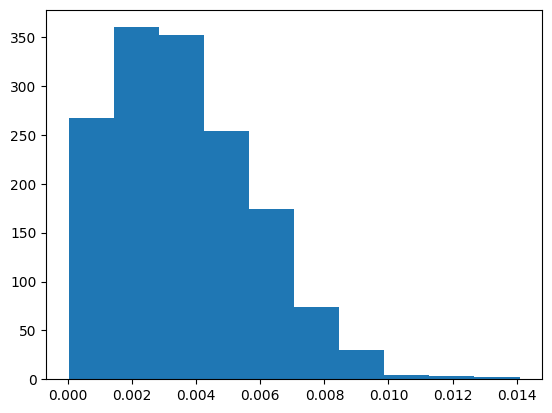

In [26]:
log_files_train = glob.glob(os.path.join(logs, "version_15/*.csv"))[0]
# log_files_val = glob.glob(os.path.join(logs, "version_3/*.csv"))[0]
csv = pd.read_csv(log_files_train)

In [21]:
example_files = glob.glob(examples + '*test*')
example_files.sort()
print(example_files)

['../models/experiments/earthformer/examples/test_epoch_60_data_0.png', '../models/experiments/earthformer/examples/test_epoch_60_data_160.png', '../models/experiments/earthformer/examples/test_epoch_60_data_240.png', '../models/experiments/earthformer/examples/test_epoch_60_data_320.png', '../models/experiments/earthformer/examples/test_epoch_60_data_400.png', '../models/experiments/earthformer/examples/test_epoch_60_data_80.png']


../models/experiments/earthformer/examples/test_epoch_60_data_80.png


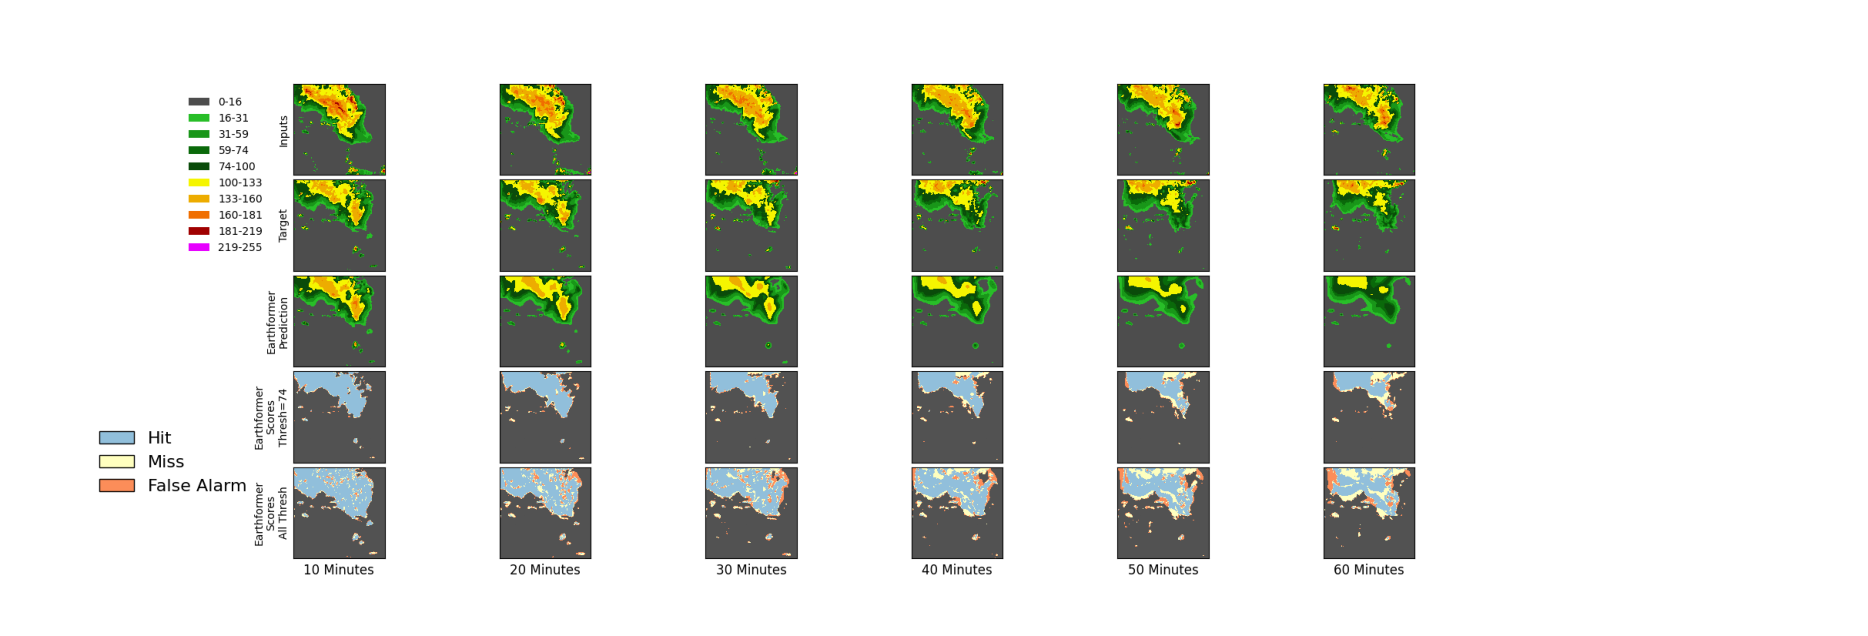

In [22]:
file = example_files[-1]
print(file)
img = mpimg.imread(file)
plt.figure(figsize=(24, 8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
test_loader = dm.test_dataloader()

In [ ]:
len(test_loader)

In [31]:
mses = []
maes = []
for batch_idx, batch in enumerate(test_loader):
    if batch_idx % 1000 == 0:
        print(batch_idx)
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    y_hat, _, _, edl_params = pl_module(x, y)
    if pl_module.oc.trainer.precision == 16:
        y_hat = y_hat.float()
    step_mse = pl_module.test_mse(y_hat, y)
    step_mae = pl_module.test_mae(y_hat, y)
    mses.append( step_mse.detach().cpu().numpy() )
    maes.append( step_mae.detach().cpu().numpy() )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


(array([4.749e+03, 2.844e+03, 2.400e+03, 1.291e+03, 5.830e+02, 2.000e+02,
        6.700e+01, 1.700e+01, 4.000e+00, 4.000e+00]),
 array([2.48896285e-05, 2.58649932e-03, 5.14810905e-03, 7.70971878e-03,
        1.02713285e-02, 1.28329387e-02, 1.53945480e-02, 1.79561581e-02,
        2.05177683e-02, 2.30793767e-02, 2.56409869e-02]),
 <BarContainer object of 10 artists>)

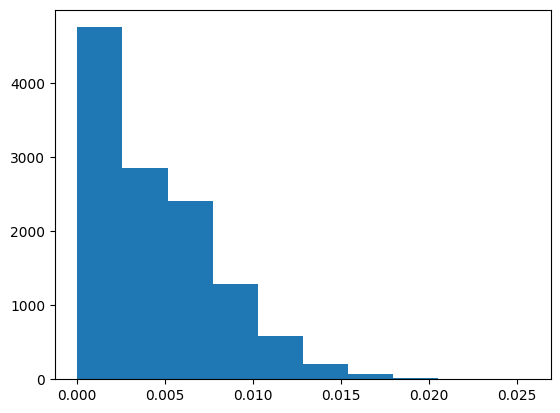

In [32]:
plt.hist(mses)

(array([3370., 2238., 2110., 1929., 1368.,  734.,  311.,   78.,   16.,
           5.]),
 array([0.00406965, 0.01473223, 0.02539482, 0.03605741, 0.04671999,
        0.05738258, 0.06804516, 0.07870775, 0.08937033, 0.10003292,
        0.1106955 ]),
 <BarContainer object of 10 artists>)

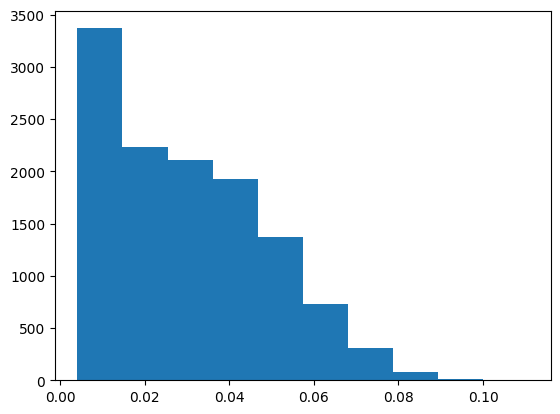

In [33]:
plt.hist(maes)